# Fitting a Motion Path Using Splines

In this notebook, we explore the setting that a blur kernel is measured and the illumination values are known, but the exact motion path is not known. This will be useful for alternating minimization in autocalibration.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import scipy.interpolate as si
import matplotlib.pyplot as plt
import scipy.misc as misc
import imageio
import skimage.transform

# Operator imports
import ndoperators as ops
import llops as yp

# Libwallerlab imports
from ndoperators.solvers import iterative, objectivefunctions
import libwallerlab.projects.motiondeblur as md
import libwallerlab.algorithms
import libwallerlab.utilities.simulation as sim
from libwallerlab.utilities import fourier

Ft = fourier.Ft
iFt = fourier.iFt

# Define global backend and dtype
global_backend = 'numpy'
global_dtype = 'complex32' # same as np.complex64
np_dtype = np.complex64




<IPython.core.display.Javascript object>


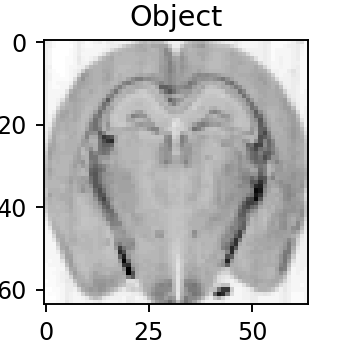

Text(0.5,1,'Object')

In [3]:
object_size = np.array([64,64])
image_size = object_size
n_illum = 20

object_center = object_size/2

x_start = object_center[1] - n_illum/2
y_start = object_center[0]

x_offset = - n_illum/2
y_offset= 0

# Create test object
# TODO: weird border issue, this is a hack
brain = sim.testObject('brain', image_size+np.array([2,2]), color_channel=2, dtype=yp.getNativeDatatype(global_dtype, 'numpy'))
object_true = brain[1:-1,1:-1]


plt.figure(figsize=(2,2))
plt.imshow(np.abs(object_true), cmap='gray')
plt.title('Object')

## Operator Library PhaseRamp Error

The phaseramp from the operator library doesn't pass gradient check by a fairly large vaue (around 1, and this doesn't change when I remove the conjugate() from the gradient expression), but the concatentation of ops.Exponential and ops.MatrixMultiply does.

Using the chained operators to define the PhaseRamp is not ideal becase it necessitates a reshape.

In [25]:
H = ops.PhaseRamp(object_size, dtype=global_dtype, backend=global_backend) # * np.array([ys_offset[t], xs_offset[t]], dtype=np.complex64)
H.gradient_check()

4.8514943e-09

In [26]:
m = np.asarray([H.ry.ravel(), H.rx.ravel()]).T

EXP = ops.Exponential(object_size, dtype=global_dtype, backend=global_backend)
M = ops.MatrixMultiply(m, dtype=global_dtype, backend=global_backend)

ramp2 = EXP * M

ramp2.gradient_check()

0.0004011066

## Creating the true motion path and measured blur kernel

We denote a vector of illumination values $\begin{bmatrix} v_1 & \dots & v_p \end{bmatrix}$ occuring at evenly spaced times, $t=0,\dots,p-1$. At $t=0$, we know the position of the stage, $(x_\text{start}, y_\text{start})$. The stage then moves along some motion path 
$$r(t) = (x(t),y(t)) = (x_\text{start} + f_x(t), y_\text{start} + f_y(t))$$
Below, we specify $f_x(t)$ to be a scaled and shifted sigmoid function, and $f_y(t)$ to be a sine curve. 

<IPython.core.display.Javascript object>


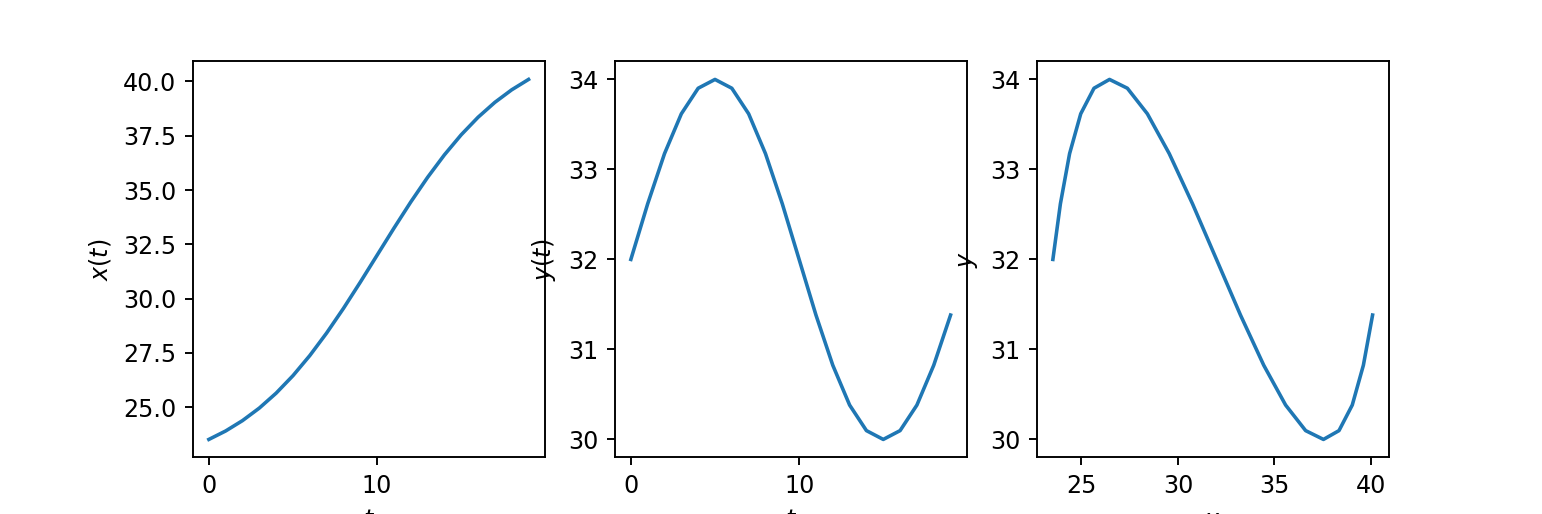

Text(0,0.5,'$y$')

In [27]:
illums = np.random.uniform(size=n_illum)

# x_fn = lambda t: n_illum * (t+1)**(2)/(n_illum+1)**(2)
sigmoid = lambda x: 1 / (1 + np.exp(-(x)))
x_fn = lambda t: (n_illum * sigmoid(5 * (t / n_illum - 1/2)))

# quartic = lambda x: (x+1)**4 - 4*(x+1)**3 - 2*(x+1)**2 + 12*(x+1) - 3
# y_fn = lambda t: 2 * quartic((t-n_illum/2)/(n_illum/7)) / quartic((n_illum-n_illum/2)/(n_illum/7))
y_fn = lambda t: (2 * np.sin(t * 2*np.pi / n_illum))

xs = [x_start+x_fn(t) for t in range(n_illum)]
ys = [y_start+y_fn(t) for t in range(n_illum)]

plt.figure(figsize=(9,3)); plt.subplot(131)
plt.plot(xs); plt.xlabel('$t$'); plt.ylabel('$x(t)$')
plt.subplot(132)
plt.plot(ys); plt.xlabel('$t$'); plt.ylabel('$y(t)$')
plt.subplot(133)
plt.plot(xs,ys); plt.xlabel('$x$'); plt.ylabel('$y$')

### Blur kernel

The resulting blur kernel is $ h = \sum_{t=1}^p v_t \delta_{r(t)} $

In [28]:
position_list = []
for x,y in zip(xs,ys):
    position_list.append([y,x])
    
xs_offset = [x_offset+x_fn(t) for t in range(n_illum)]
ys_offset = [y_offset+y_fn(t) for t in range(n_illum)]

xs_offset_straight = [x_offset+t for t in range(n_illum)]
ys_offset_straight = [y_offset for t in range(n_illum)]

<IPython.core.display.Javascript object>


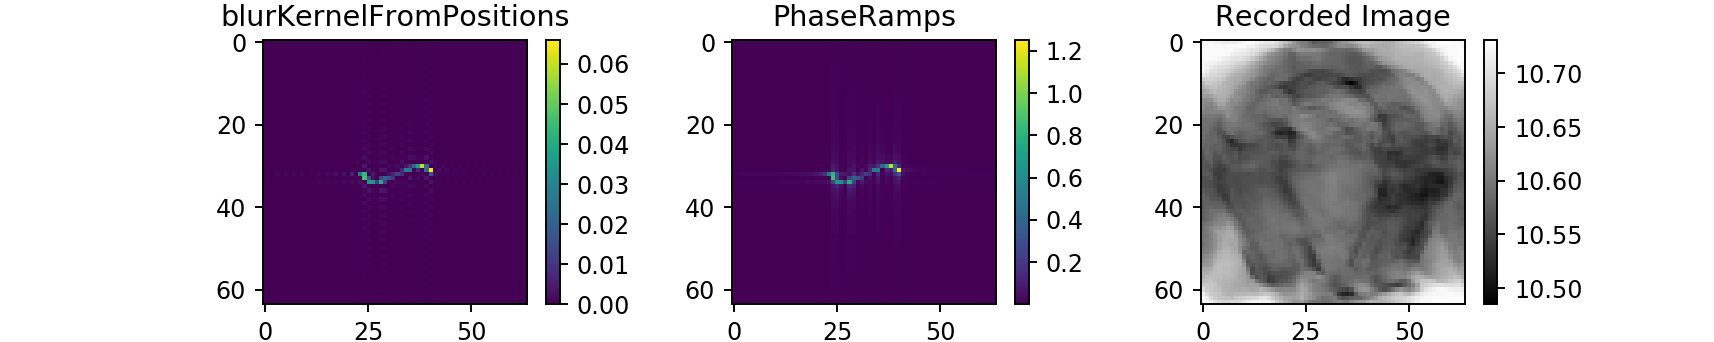

Text(0.5,1,'Recorded Image')

In [29]:
blur_kernel = md.blurkernel.blurKernelFromPositions(object_size, position_list, illums, use_phase_ramp=True)

Hs = []
H = ops.PhaseRamp(object_size, dtype=global_dtype, backend=global_backend) # * np.array([ys_offset[t], xs_offset[t]], dtype=np.complex64)
for t in range(n_illum):
    Hs.append(illums[t] * H * np.array([ys_offset[t], xs_offset[t]], dtype=np_dtype))
blur_kernel_phaseramp_true = sum(Hs)
F = ops.FourierTransform(object_size, dtype=global_dtype, backend=global_backend)

image_recorded_true = F.H * (blur_kernel_phaseramp_true * (F * object_true.astype(np_dtype)))

plt.figure(figsize=(10,2)); plt.subplot(1,3,1)
plt.imshow(np.abs(blur_kernel)); plt.colorbar(); plt.title('blurKernelFromPositions')

plt.subplot(1,3,2)
plt.imshow(np.abs(F.H * blur_kernel_phaseramp_true).reshape(object_size)); plt.colorbar()
plt.title('PhaseRamps')
plt.subplot(1,3,3)
plt.imshow(np.abs(image_recorded_true).reshape(object_size), cmap='gray'); plt.colorbar()
plt.title('Recorded Image')

# Forward Operation

In the above setup, we went from recorded illuminations to a blur kernel using parametrized curves. We can reformulate the procedure as an operator parametrized by illuminations that acts on curve parameters. 
$$ \tilde B = \sum_{t=1}^p v_t \tilde\delta_{r(t)} =  \sum_{t=1}^p v_t \exp(Mr(t)) =  \sum_{t=1}^p v_t \exp(Mr_\text{start}) \exp(M_xf_x(t) + M_yf_y(t)) $$
We can pick a prespecified parametric family of curves where $f_x(t) \approx g(t, \theta_x)$ and  $f_y(t) \approx h(t, \theta_y)$. Then the blur kernel can be written as a sum of the following chain of operators: `v_t * Exp * M * vstack(G_t,H_t)`, ready to operate on some parameters $\theta$. This $\theta$ will be the same for all $t$, so the problem is a compact sum (compared with the independent position formulation).

### Remark about parametrization

In the above, we consider the parametrization $r(t) = (f_x(t), f_y(t))$. This formulation allows us to think about the motion of the stage in $x$ and $y$ independently, and has direct physical interpretations. Using physical intuition, we may be able to consider reasonable constraints on $f_x$ and $f_y$.

However, we can visually inspect the empirical blur kernels based on deconvolving from a strobed image. In this case, we think of the shape of the curve as $y=f(x)$. In particular, we draw conclusions about the complexity of $f$ directly based on the observed blur kernels, imagining it to be well approximated by splines. It is not totally clear how this intuition transfers to $f_y$ because the form of $f_x$ may be complex.

However, the two perspectives can be reconciled because we simply have that $f(x) = f_y(f_x^{-1}(x))$. (The inverse will always exist when $f_x$ is monotonic.) If we want to constraint the form of $f(x)$ to be in some family of functions $F(x,\theta_y)$, then we can simply set the problem up as
$$ \tilde B = \sum_{t=1}^p v_t \exp(Mr_\text{start}) \exp(M_xf_x(t) + M_yf(f_x(t))) $$
Or with operators, `v_t * Exp * M * vstack(G_t,F * G_t)`. This seems somewhat less natural, but we could go either way.


## Function approximation with B-Splines

We will chose the class of functions $G$ and $H$ to be parametrized by B-Spline basis functions.

<IPython.core.display.Javascript object>


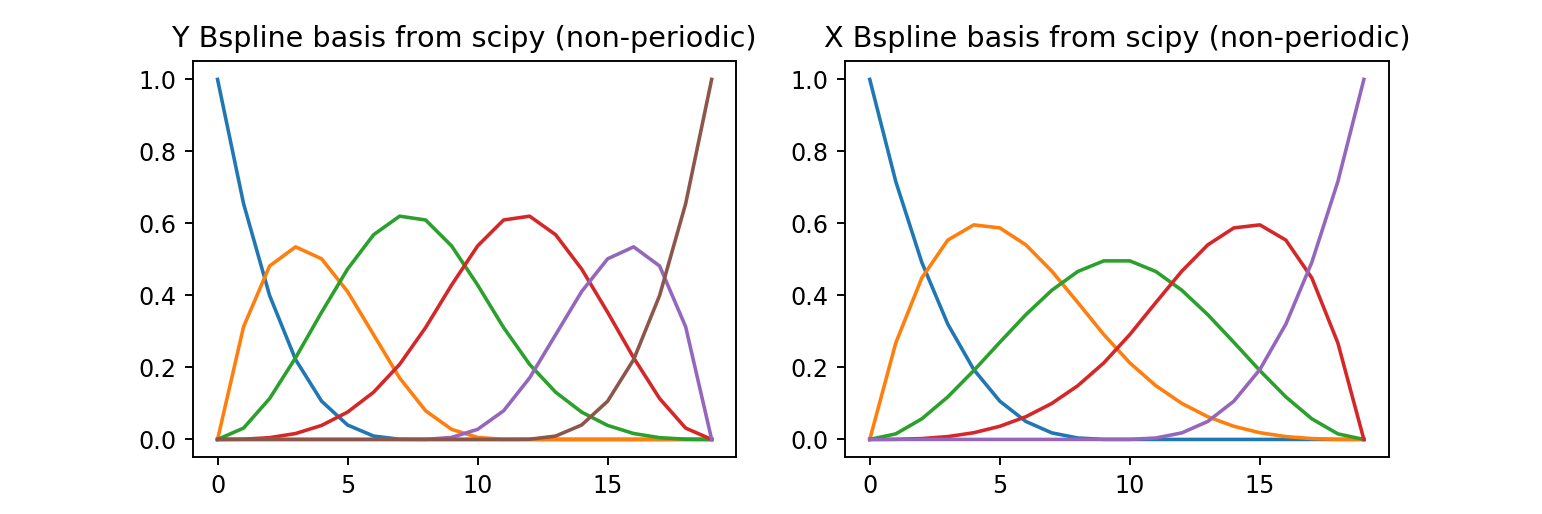

Text(0.5,1,'X Bspline basis from scipy (non-periodic)')

In [31]:
n_basis_splines = [6,5]
values_sep_y = md.blurkernel.get_basis_splines(n_illum, n_basis_splines[0]).T
values_sep_x = md.blurkernel.get_basis_splines(n_illum, n_basis_splines[1]).T

# start plotting
f, ax = plt.subplots(1, 2, figsize=(9,3))
ax1, ax2 = ax
for vals in values_sep_y:
    ax1.plot(vals)
ax1.set_title('Y Bspline basis from scipy (non-periodic)')

#f, ax1 = plt.subplots(1, 1, figsize=(9,3))
for vals in values_sep_x:
    ax2.plot(vals)
ax2.set_title('X Bspline basis from scipy (non-periodic)')


### Restricting curves to be monotonic

It is reasonable to consider that the montion path will be monotonic, especially in the x-direction. Recall that the predicted curve takes the form

$$ \begin{bmatrix} \hat x(1) \\ \vdots \\ \hat x(n_{sample}) \end{bmatrix} = \begin{bmatrix} \text{spl}_1(1) & \dots & \text{spl}_{n_{coeffs}}(1) \\ \vdots && \vdots \\ \text{spl}_{1}(n_{sample}) & & \text{spl}_{n_{coeffs}}(n_{sample}) \end{bmatrix} \begin{bmatrix} w_1 \\ \vdots \\ w_{n_{coeffs}} \end{bmatrix} = \begin{bmatrix} \mathbf{Spl}(1)^\top \mathbf{w} \\ \vdots \\ \mathbf{Spl}(n_{coeffs})^\top \mathbf{w} \end{bmatrix} $$ 

Then monotonicity is implied by, for $i=1,...,n_{sample}-1$

$$ x(i) \leq x(i+1) \iff (\mathbf{Spl}(i) - \mathbf{Spl}(i+1))^\top \mathbf{w} \leq 0\:.  $$

Therefore, we can impose the constraint on the weights that
$$  \begin{bmatrix}  (\mathbf{Spl}(1) - \mathbf{Spl}(2))^\top \\ \vdots \\ (\mathbf{Spl}(n_{coeffs}-1) - \mathbf{Spl}(n_{coeffs}))^\top \end{bmatrix}  \mathbf{w} := Dw \leq 0\:.  $$

In general, handling inequality constraints [can be difficult](https://math.stackexchange.com/questions/381602/gradient-descent-with-inequality-constraints?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa), and we use the following strategy (which is not particularly computationally efficient). To project a weight vector $z$ onto the set $\{w~:~Dw\leq 0\}$, we start by characterizing the *active constraints*, i.e. the set of indices $a = \{i~:~(Dz)_{i} = d_i^\top z > 0\}$. If no constraints are active, then $z$ is already in the desired set.

Active constraints will be at the set boundary after projection, so we project $z$ onto the nullspace of $D_a$. This is accomplished by the projection matrix
$$ P = I - D_a^\top (D_a D_a^\top)^{-1} D_a\:. $$
Remark that $D$ is generally tall and thin, meaning that $D_a D_a^\top$ may not be full rank. For now, we use the pseudoinverse, though it is not clear that this is the right thing to do.


In [32]:
def get_monotone_projection(spline_basis):
    A = spline_basis[:-1] - spline_basis[1:]
    return lambda x: project_inequality(A, x)

def project_inequality(A, x):
    # projection onto Ax <= 0
    # TODO assumes A is real
    # TODO check that this is actually working: seems that resulting x is in full A nullspace...
    A_active = A[np.where(A.dot(x) > 0)[0]]
    if len(A_active.shape) < 2:
        A_active = np.expand_dims(A_active,1)
    if A_active.shape[0] == 0:
        return x
    AAinv = np.linalg.pinv(A_active.dot(A_active.T))
    P = A_active.T.dot(AAinv).dot(A_active)
    Px = P.dot(x)
    return x - Px


## Fitting Full XY-curves using gradient descent

We will minimize 
$$ \| [y(t)]_{t=1}^{n_{samples}} - \sum_{i=1}^{n_{coeffs}} w_i[\text{spl}_i(t)]_{t=1}^{n_{samples}} \|_2^2 = \Big\| \begin{bmatrix} y(1) \\ \vdots \\ y(n_{sample}) \end{bmatrix} - \begin{bmatrix} \text{spl}_1(1) & \dots & \text{spl}_{n_{coeffs}}(1) \\ \vdots && \vdots \\ \text{spl}_{1}(n_{sample}) & & \text{spl}_{n_{coeffs}}(n_{sample}) \end{bmatrix} \begin{bmatrix} w_1 \\ \vdots \\ w_{n_{coeffs}} \end{bmatrix} \Big\|_2^2 $$
So this could actually be solved as a least-squares problem. However, when we incorporate the blurkernel and operators, gradient methods will be more general.
The gradient is
$$ \nabla \| \mathbf{y} - \mathbf{\text{Spl}} \cdot \mathbf{w} \|_2^2 = 2 \mathbf{\text{Spl}}^\top \Big(\mathbf{y} - \mathbf{\text{Spl}} \cdot \mathbf{w} \Big)  $$

In [35]:
spl_y = md.blurkernel.get_basis_splines(n_illum, n_basis_splines[0])
spl_x = md.blurkernel.get_basis_splines(n_illum, n_basis_splines[1])


w_0_y = np.zeros(spl_y.shape[1])
w_0_x = np.zeros(spl_x.shape[1])
w_y = w_0_y
w_x = w_0_x

proj_x = md.blurkernel.get_monotone_projection(spl_x)


def gradwy(w_y):
    return spl_y.T.dot( ys_offset - spl_y.dot(w_y))

def gradwx(w_x):
    return spl_x.T.dot( xs_offset - spl_x.dot(w_x))

for i in range(100):
    w_y = w_y + 0.1 * gradwy(w_y)
for i in range(100):
    # to do: require weights such that monotonic curve
    w_x = proj_x(w_x + 0.1 * gradwx(w_x))

<IPython.core.display.Javascript object>


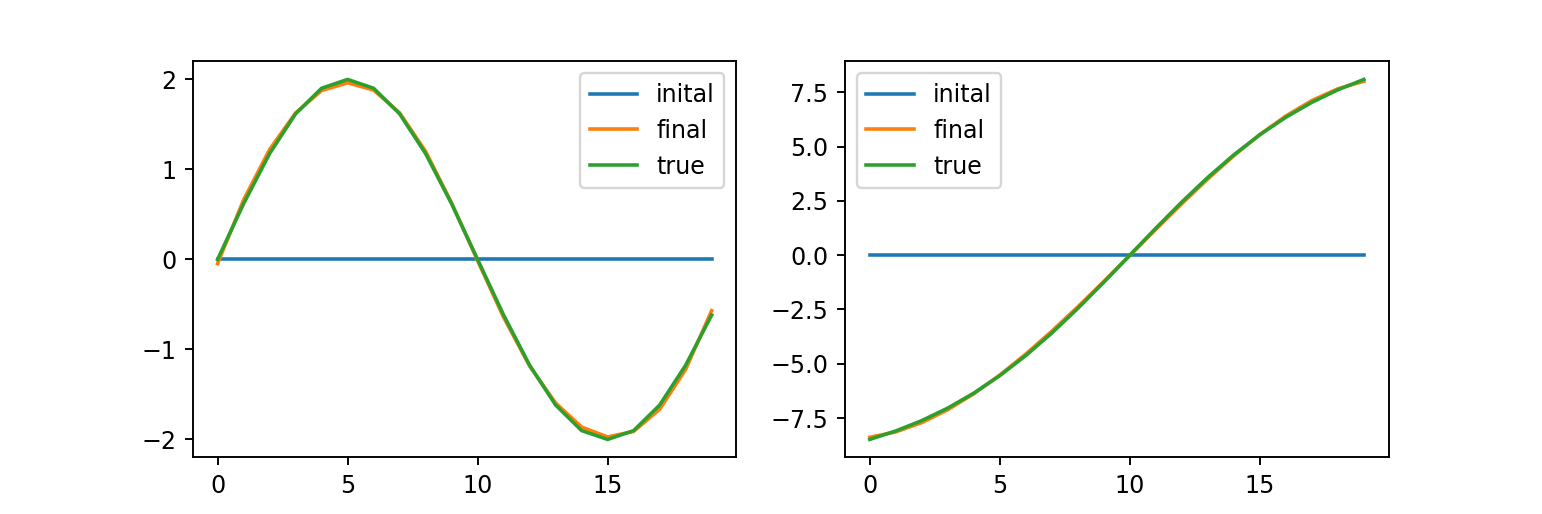

In [36]:
yhat = spl_y.dot(w_y)
xhat = spl_x.dot(w_x)
xhat_0 = spl_x.dot(w_0_x)
yhat_0 = spl_y.dot(w_0_y)

plt.figure(figsize=(9,3)); plt.subplot(1,2,1)
plt.plot(yhat_0, label='inital'); plt.plot(yhat, label='final'); 
plt.plot(ys_offset, label = 'true'); plt.legend()

plt.subplot(1,2,2); plt.plot(xhat_0, label='inital'); plt.plot(xhat, label='final'); 
plt.plot(xs_offset, label = 'true'); plt.legend()

In [37]:
# defining the weights for a strait path, since this is a default initialization strategy
w_y_straight = w_0_y
w_x_straight = w_0_x

def gradwy(w_y):
    return spl_y.T.dot( ys_offset_straight - spl_y.dot(w_y))
def gradwx(w_x):
    return spl_x.T.dot( xs_offset_straight - spl_x.dot(w_x))

for i in range(100):
    w_y_straight = w_y_straight + 0.1 * gradwy(w_y_straight)
for i in range(100):
    # to do: require weights such that monotonic curve
    w_x_straight = w_x_straight + 0.1 * gradwx(w_x_straight)

## Defining forward model from weights to blur kernel

$\tilde B = \sum_{t=1}^p v_t\exp(M S w)$

In [38]:
B = ops.BlurKernelBasis(object_size, (spl_y, spl_x), illums, dtype=global_dtype, backend=global_backend)
B.gradient_check() #(np.hstack([w_y,w_x]).astype(np_dtype))

forward with position: (0.7736564+0j) (0.7214037+0j)
forward with position: (0.77355635+0j) (0.7212616+0j)
0.7736064 0.72133267 0.9524471987912293


forward with position: (0.7736064+0j) (0.72133267+0j)


AssertionError: Gradient was off by 1.9735e-03 (threshold is 2.8849e-04)

In [39]:
w = np.hstack([w_y,w_x]).astype(np_dtype)
L2 = ops.L2Norm(object_size, dtype=global_dtype, backend=global_backend)


In [40]:
# old construction method: TODO convert into testing example

H = ops.PhaseRamp(object_size, dtype=global_dtype, backend=global_backend)
m = np.asarray([H.ry.ravel(), H.rx.ravel()]).T

SPLs = []
for t in range(n_illum):
    spl_block = np.vstack([ np.hstack([spl_y[t], np.zeros(spl_x[t].shape)]),\
                           np.hstack([np.zeros(spl_y[t].shape), spl_x[t]]) ])
    # TODO: move away from matrix definition
    SPLs.append(ops.MatrixMultiply(m.dot(spl_block), dtype=global_dtype, backend=global_backend))

EXP = ops.Exponential(object_size, dtype=global_dtype, backend=global_backend)

Hsum = illums[0] * EXP * SPLs[0]
for t in range(1,n_illum):
    Hsum = Hsum + illums[t] * EXP * SPLs[t]

b1 = Hsum * w
b2 = B * w

print('max forward operator difference:', np.amax(np.abs(b1- b2)))
graddiff = (L2 * B).gradient(w) - (L2 * Hsum).gradient(w)

print('max gradient difference:', np.amax(np.abs(graddiff)))


forward with position: (1.9628292+0j) (8.009403+0j)
max forward operator difference: 1676456500000.0
1.972255 8.382026 0.9524471987912293


forward with position: (1.9628292+0j) (8.009403+0j)
max gradient difference: 4.4871142e+25


## Comparing weight-generated blur kernel with original
It appears that the path resulting from splines may be a pixel off in certain places, resulting in a noticeable difference in the blur path. This may be reduced by choosing a larger number of basis function. However, since the spline weights were not fit using the blur kernel shape directly, this is not a completely fair comparison.

forward with position: (1.9628292+0j) (8.009403+0j)


<IPython.core.display.Javascript object>


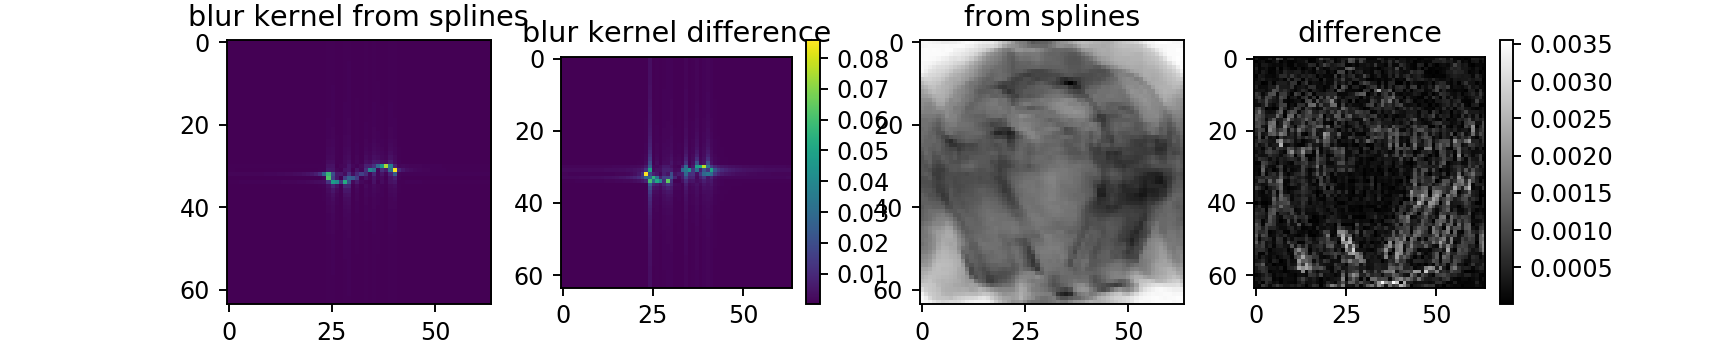

In [41]:
# constructing blur kernels from the motion path splines 
blur_kernel_phaseramp = B * np.hstack([w_y,w_x]).astype(np_dtype)
image_recorded = F.H * (blur_kernel_phaseramp * (F * object_true.astype(np_dtype)))

F = ops.FourierTransform(object_size, dtype=global_dtype, backend=global_backend)
plt.figure(figsize=(10,2));
plt.subplot(141); plt.imshow(np.abs(F.H * blur_kernel_phaseramp).reshape(object_size))
plt.title('blur kernel from splines')
plt.subplot(142); plt.imshow(np.abs(F.H * blur_kernel_phaseramp_true.astype(np_dtype) - F.H * blur_kernel_phaseramp).reshape(object_size))
plt.title('blur kernel difference')
plt.colorbar()

plt.subplot(143); plt.imshow(np.abs(image_recorded).reshape(object_size), cmap='gray')
plt.title('from splines')
plt.subplot(144); plt.imshow(np.abs(image_recorded - image_recorded_true).reshape(object_size), cmap='gray')
plt.title('difference')
plt.colorbar()

# Fitting Blur Kernel Using Splines

Next, we want to use only the blur kernel to fit the spline weights.

We will minimize 
$$ \| \tilde B - \sum_{t=1}^p v_t \exp(Mr_\text{start}) \exp(M_x\sum_{i=1}^{n_{coeffs}} w_i\text{spl}^x_i(t) + M_y\sum_{i=1}^{n_{coeffs}} w_i\text{spl}^y_i(t)) \|_2^2 $$
In operator language, we have the sum of products: `v_t * Exp * M * Diagstack(splx_t,sply_t) * vstack(w_x, w_y)`.

In [42]:
w = np.hstack([w_y,w_x]).astype(np_dtype)
L2 = ops.L2Norm(object_size, dtype=global_dtype, backend=global_backend)

objective = L2 * (F.H * B - F.H * blur_kernel_phaseramp_true.astype(np_dtype))

# for projecting the X splines -- not clear that this makes a huge difference
# if anything, might be bad?
proj = lambda w: np.vstack([w[:n_basis_splines[0]], proj_x(w[n_basis_splines[0]:]).astype(np_dtype)])


In [43]:
objective.gradient_check()

forward with position: (0.50176054+0j) (0.86020845+0j)
forward with position: (0.50164+0j) (0.86018115+0j)
0.5017003 0.86019474 0.9524471987912293


forward with position: (0.5017003+0j) (0.86019474+0j)


0.902286

### Importance of Initialization

An initialization that follows the correct general curvature is more successful that, for example, the straight initialization. 

Minimizing function:


<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


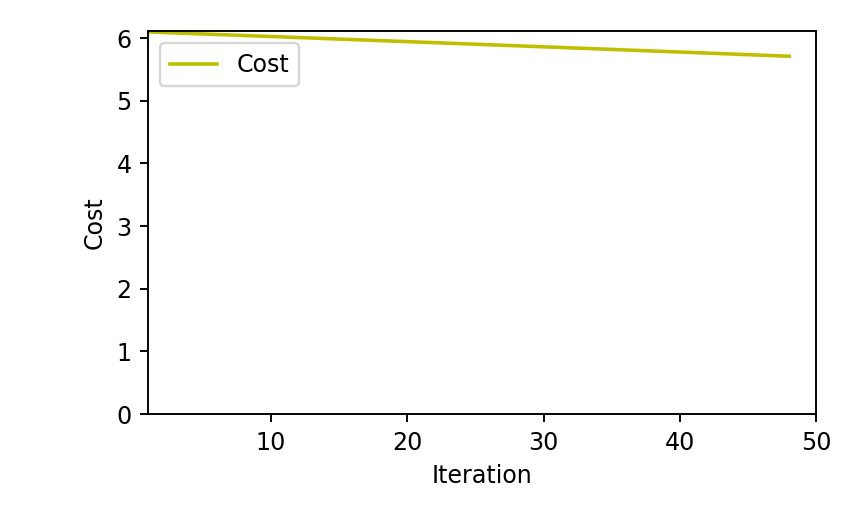

forward with position: (2.5618386+0j) (8.521179+0j)
2.5618386 8.521179 0.9524471987912293


forward with position: (2.5618386+0j) (8.521179+0j)
forward with position: (36.279522+3.8310204j) (-2.884304+1.7927442j)
forward with position: (2.5618386+0j) (8.521179+0j)
forward with position: (32.48466+3.4479184j) (-1.7437553+1.6134696j)
forward with position: (29.06929+3.1031268j) (-0.71726227+1.4521228j)
forward with position: (25.995453+2.792814j) (0.20658207+1.3069105j)
forward with position: (23.229+2.5135324j) (1.0380416+1.1762195j)
forward with position: (20.739191+2.2621794j) (1.7863555+1.0585974j)
forward with position: (18.498365+2.0359614j) (2.4598374+0.95273775j)
forward with position: (16.48162+1.8323653j) (3.0659719+0.857464j)
forward with position: (14.666552+1.6491287j) (3.6114926+0.77171755j)
forward with position: (13.032988+1.4842159j) (4.1024613+0.6945458j)
forward with position: (11.562781+1.3357942j) (4.544333+0.62509125j)
forward with position: (10.239594+1.2022148j) (

forward with position: (4.0313797+0.5734889j) (6.8039293+0.26557368j)
forward with position: (3.4614348+0.5161502j) (6.975624+0.23902108j)
forward with position: (2.948484+0.46454534j) (7.1301494+0.21512373j)
forward with position: (2.4868288+0.418101j) (7.2692223+0.19361612j)
forward with position: (2.0713387+0.37630108j) (7.3943872+0.17425928j)
forward with position: (1.6973976+0.33868113j) (7.507036+0.1568381j)
forward with position: (1.3608509+0.3048232j) (7.6084204+0.14115906j)
forward with position: (1.0579587+0.27435106j) (7.699666+0.12704793j)
forward with position: (0.78535545+0.24692613j) (7.781787+0.114347875j)
forward with position: (0.54001296+0.2222437j) (7.8556957+0.10291786j)
forward with position: (0.31920457+0.2000295j) (7.9222136+0.092630826j)
forward with position: (0.19358057+0.15377967j) (7.98208+0.08337251j)
forward with position: (0.43027484+0.13841031j) (8.035959+0.07504002j)
forward with position: (0.6432997+0.12457787j) (8.084452+0.06754078j)
forward with pos

forward with position: (1.9573443+0.03883739j) (8.382527+0.021141972j)
forward with position: (2.0175288+0.034970924j) (8.396332+0.019037236j)
forward with position: (2.0716946+0.0314911j) (8.408756+0.017142972j)
forward with position: (2.1204438+0.028359262j) (8.419938+0.015438137j)
forward with position: (2.1643186+0.025540609j) (8.430001+0.013903784j)
forward with position: (2.2038054+0.02300382j) (8.439058+0.012522866j)
forward with position: (2.2393436+0.020720711j) (8.447209+0.011280039j)
forward with position: (2.271328+0.018665912j) (8.454546+0.010161497j)
forward with position: (2.300114+0.016816592j) (8.461148+0.009154807j)
forward with position: (2.3260214+0.015152206j) (8.467091+0.008248787j)
forward with position: (2.3493383+0.013654258j) (8.472439+0.007433369j)
forward with position: (2.370323+0.012306105j) (8.477252+0.006699493j)
forward with position: (2.3892097+0.011092765j) (8.481584+0.0060390043j)
forward with position: (2.4062076+0.010000762j) (8.485483+0.005444565j

forward with position: (2.404823+0.00998535j) (8.484899+0.005457468j)
forward with position: (2.420126+0.009012666j) (8.488436+0.0049258512j)
forward with position: (2.4338987+0.008137248j) (8.491618+0.0044473964j)
forward with position: (2.4462938+0.007349374j) (8.494483+0.0040167863j)
forward with position: (2.45745+0.006640287j) (8.497062+0.003629238j)
forward with position: (2.46749+0.006002109j) (8.499382+0.0032804445j)
forward with position: (2.4765265+0.0054277484j) (8.501471+0.0029665302j)
forward with position: (2.4846594+0.0049108234j) (8.50335+0.002684007j)
forward with position: (2.4919786+0.0044455915j) (8.505041+0.0024297365j)
forward with position: (2.4985662+0.0040268824j) (8.506564+0.002200893j)
forward with position: (2.5044947+0.0036500443j) (8.507934+0.0019949337j)
forward with position: (2.5098305+0.0033108902j) (8.509167+0.0018095702j)
forward with position: (2.5146325+0.0030056513j) (8.510277+0.0016427434j)
forward with position: (2.5189548+0.0027309363j) (8.5112

forward with position: (2.5249999+0.0023254491j) (8.512617+0.0012752607j)
forward with position: (2.5281515+0.0021272441j) (8.513351+0.0011665048j)
forward with position: (2.5309882+0.0019488595j) (8.514012+0.0010686242j)
forward with position: (2.533541+0.0017883132j) (8.514606+0.0009805318j)
forward with position: (2.5358386+0.0016438217j) (8.5151415+0.00090124866j)
forward with position: (2.5379066+0.0015137794j) (8.515623+0.00082989375j)
forward with position: (2.5397677+0.0013967411j) (8.516056+0.0007656744j)
forward with position: (2.5414426+0.0012914067j) (8.516446+0.0007078769j)
forward with position: (2.5429502+0.001196606j) (8.516797+0.00065585924j)
forward with position: (2.5443068+0.001111285j) (8.517114+0.0006090433j)
forward with position: (2.5455277+0.0010344964j) (8.517398+0.000566909j)
forward with position: (2.5466266+0.00096538645j) (8.517653+0.0005289881j)
forward with position: (2.5476158+0.00090318755j) (8.517884+0.0004948593j)
forward with position: (2.5485058+0.

forward with position: (2.5479686+0.0008761796j) (8.517954+0.00048100058j)
forward with position: (2.5486898+0.00083130365j) (8.518123+0.0004562808j)
forward with position: (2.549339+0.00079091516j) (8.518275+0.00043403302j)
forward with position: (2.5499232+0.0007545655j) (8.518413+0.00041401002j)
forward with position: (2.5504494+0.0007218509j) (8.518536+0.00039598928j)
forward with position: (2.5509224+0.00069240766j) (8.518646+0.00037977064j)
forward with position: (2.5513482+0.00066590885j) (8.518746+0.0003651739j)
forward with position: (2.5517313+0.0006420599j) (8.518836+0.0003520368j)
forward with position: (2.5520763+0.00062059576j) (8.518917+0.00034021342j)
forward with position: (2.552387+0.0006012781j) (8.5189905+0.00032957236j)
forward with position: (2.5526664+0.0005838923j) (8.519055+0.00031999542j)
forward with position: (2.5529177+0.00056824496j) (8.5191145+0.00031137618j)
forward with position: (2.5531442+0.00055416237j) (8.519168+0.00030361884j)
forward with position

forward with position: (2.5513291+0.00066543696j) (8.518738+0.00036524082j)
forward with position: (2.5515807+0.00064995076j) (8.518797+0.00035667766j)
forward with position: (2.5518072+0.0006360132j) (8.51885+0.00034897082j)
forward with position: (2.5520108+0.0006234695j) (8.518898+0.00034203462j)
forward with position: (2.552194+0.00061218004j) (8.518942+0.00033579208j)
forward with position: (2.5523593+0.0006020196j) (8.518981+0.0003301738j)
forward with position: (2.552508+0.0005928752j) (8.519016+0.00032511732j)
forward with position: (2.552508+0.0005928752j) (8.519016+0.00032511732j)
2.552508 8.519016 0.9524471987912293


forward with position: (2.552508+0.0005928752j) (8.519016+0.00032511732j)
forward with position: (36.917667+3.5458188j) (-3.4706335+1.7024198j)
forward with position: (2.552508+0.0005928752j) (8.519016+0.00032511732j)
forward with position: (33.059704+3.191306j) (-2.2716684+1.5322102j)
forward with position: (29.587536+2.8722448j) (-1.1926003+1.3790219j)
forwar

forward with position: (18.896482+1.861712j) (2.0975552+0.8989416j)
forward with position: (16.840738+1.6756195j) (2.7396693+0.8090845j)
forward with position: (14.990571+1.508136j) (3.3175726+0.728213j)
forward with position: (13.3254175+1.357401j) (3.837685+0.65542877j)
forward with position: (11.82678+1.2217395j) (4.305786+0.5899229j)
forward with position: (10.478006+1.0996442j) (4.7270775+0.53096765j)
forward with position: (9.264111+0.9897584j) (5.1062393+0.47790793j)
forward with position: (8.171605+0.8908612j) (5.447485+0.43015417j)
forward with position: (7.188349+0.8018537j) (5.7546062+0.3871758j)
forward with position: (6.303418+0.7217469j) (6.0310154+0.34849524j)
forward with position: (5.506981+0.6496508j) (6.279784+0.31368273j)
forward with position: (4.790187+0.58476436j) (6.5036755+0.2823515j)
forward with position: (4.145073+0.52636653j) (6.7051773+0.25415337j)
forward with position: (3.56447+0.47380853j) (6.8865294+0.22877508j)
forward with position: (3.0419276+0.4265

forward with position: (3.0555086+0.4213925j) (7.0380945+0.2046088j)
forward with position: (2.5839653+0.37934119j) (7.186123+0.18418945j)
forward with position: (2.159576+0.341495j) (7.319348+0.16581203j)
forward with position: (1.7776257+0.3074334j) (7.439251+0.14927235j)
forward with position: (1.4338704+0.27677798j) (7.5471635+0.13438664j)
forward with position: (1.1244906+0.2491881j) (7.6442847+0.1209895j)
forward with position: (0.8460487+0.22435719j) (7.7316937+0.10893207j)
forward with position: (0.59545124+0.2020094j) (7.810362+0.09808039j)
forward with position: (0.36991346+0.18189636j) (7.8811636+0.08831388j)
forward with position: (0.17716396+0.14223269j) (7.944885+0.07952401j)
forward with position: (0.41443086+0.12808491j) (8.0022335+0.07161313j)
forward with position: (0.627971+0.115351915j) (8.053848+0.06449334j)
forward with position: (0.8201572+0.103892215j) (8.100301+0.058085535j)
forward with position: (0.9931247+0.09357849j) (8.142109+0.052318506j)
forward with pos

forward with position: (1.287226+0.075246945j) (8.210936+0.04221806j)
forward with position: (1.4133527+0.067805715j) (8.241648+0.038042236j)
forward with position: (1.5268669+0.06110862j) (8.269288+0.034283996j)
forward with position: (1.6290296+0.055081226j) (8.294165+0.030901585j)
forward with position: (1.7209762+0.04965658j) (8.316553+0.027857408j)
forward with position: (1.8037282+0.04477439j) (8.336703+0.025117652j)
forward with position: (1.8782047+0.040380426j) (8.354838+0.022651874j)
forward with position: (1.9452337+0.036425855j) (8.37116+0.020432672j)
forward with position: (2.0055597+0.032866742j) (8.385849+0.018435389j)
forward with position: (2.0598533+0.02966354j) (8.39907+0.016637836j)
forward with position: (2.1087174+0.02678066j) (8.410968+0.015020036j)
forward with position: (2.1526952+0.024186064j) (8.421677+0.013564018j)
forward with position: (2.192275+0.02185093j) (8.431314+0.0122536j)
forward with position: (2.2278972+0.01974931j) (8.439988+0.0110742245j)
forwa

forward with position: (2.2264762+0.01963329j) (8.439064+0.011046582j)
forward with position: (2.2585442+0.01776133j) (8.446931+0.00999234j)
forward with position: (2.2874053+0.016076563j) (8.45401+0.009043522j)
forward with position: (2.3133807+0.014560277j) (8.4603815+0.008189585j)
forward with position: (2.336758+0.013195616j) (8.466116+0.007421043j)
forward with position: (2.3577979+0.011967423j) (8.471277+0.006729355j)
forward with position: (2.3767338+0.01086205j) (8.475923+0.006106835j)
forward with position: (2.393776+0.009867213j) (8.480103+0.0055465675j)
forward with position: (2.4091144+0.00897186j) (8.483865+0.0050423266j)
forward with position: (2.4229183+0.008166042j) (8.487251+0.0045885104j)
forward with position: (2.435342+0.0074408054j) (8.490299+0.0041800747j)
forward with position: (2.4465237+0.006788094j) (8.493042+0.0038124835j)
forward with position: (2.4565868+0.006200652j) (8.49551+0.0034816512j)
forward with position: (2.465644+0.0056719556j) (8.497732+0.003183

forward with position: (2.479776+0.0048062913j) (8.50108+0.002703895j)
forward with position: (2.48638+0.0044248453j) (8.502711+0.0024883226j)
forward with position: (2.4923239+0.0040815435j) (8.50418+0.002294307j)
forward with position: (2.4976735+0.0037725717j) (8.505502+0.0021196932j)
forward with position: (2.5024877+0.0034944974j) (8.506692+0.0019625407j)
forward with position: (2.5068207+0.0032442305j) (8.507763+0.0018211037j)
forward with position: (2.5107205+0.0030189904j) (8.508726+0.0016938102j)
forward with position: (2.51423+0.002816274j) (8.509593+0.0015792461j)
forward with position: (2.517389+0.0026338296j) (8.510374+0.0014761385j)
forward with position: (2.5202317+0.0024696293j) (8.511076+0.0013833416j)
forward with position: (2.5227907+0.002321849j) (8.511708+0.0012998243j)
forward with position: (2.525093+0.0021888474j) (8.512278+0.0012246589j)
forward with position: (2.5271657+0.0020691454j) (8.51279+0.0011570099j)
forward with position: (2.5290308+0.0019614135j) (8.

forward with position: (2.521446+0.0023854745j) (8.511334+0.001338345j)
forward with position: (2.5237489+0.0022538442j) (8.511908+0.0012636983j)
forward with position: (2.5258222+0.0021353767j) (8.5124235+0.0011965163j)
forward with position: (2.5276878+0.0020287556j) (8.512888+0.0011360524j)
forward with position: (2.529367+0.001932797j) (8.513307+0.001081635j)
forward with position: (2.5308778+0.0018464342j) (8.513682+0.0010326593j)
forward with position: (2.5322382+0.0017687076j) (8.514021+0.0009885811j)
forward with position: (2.5334623+0.0016987538j) (8.514326+0.0009489108j)
forward with position: (2.5345638+0.0016357952j) (8.5146+0.0009132075j)
forward with position: (2.5355551+0.0015791325j) (8.514847+0.00088107446j)
forward with position: (2.5364478+0.0015281362j) (8.515069+0.00085215486j)
forward with position: (2.5372508+0.0014822395j) (8.515268+0.0008261271j)
forward with position: (2.5379736+0.0014409324j) (8.515449+0.0008027022j)
forward with position: (2.538624+0.0014037

forward with position: (2.540027+0.0013216907j) (8.515954+0.0007354187j)
forward with position: (2.5403385+0.0013040927j) (8.516032+0.0007254053j)
forward with position: (2.5406184+0.0012882546j) (8.516102+0.00071639323j)
forward with position: (2.5408702+0.0012740004j) (8.516165+0.00070828234j)
forward with position: (2.5410976+0.0012611714j) (8.516222+0.0007009826j)
forward with position: (2.5413017+0.0012496256j) (8.5162735+0.0006944128j)
forward with position: (2.5414853+0.001239234j) (8.516319+0.0006885j)
forward with position: (2.5416508+0.0012298818j) (8.516361+0.0006831784j)
forward with position: (2.5417998+0.0012214648j) (8.516398+0.00067838904j)
forward with position: (2.5417998+0.0012214648j) (8.516398+0.00067838904j)
2.5418 8.516398 0.9524471987912293


forward with position: (2.5417998+0.0012214648j) (8.516398+0.00067838904j)
forward with position: (37.760975+3.2163186j) (-4.2253666+1.6121237j)
forward with position: (2.5417998+0.0012214648j) (8.516398+0.00067838904j)
for

2.54046 8.51606 0.9524471987912293


forward with position: (2.5404599+0.0012964364j) (8.51606+0.0007211913j)
forward with position: (37.86847+3.1778324j) (-4.321213+1.60077j)
forward with position: (2.5404599+0.0012964364j) (8.51606+0.0007211913j)
forward with position: (33.91636+2.860199j) (-3.0374851+1.4407651j)
forward with position: (30.359459+2.5743291j) (-1.8821316+1.2967608j)
forward with position: (27.158245+2.3170462j) (-0.84231186+1.1671568j)
forward with position: (24.277153+2.0854914j) (0.09352493+1.0505133j)
forward with position: (21.684174+1.8770921j) (0.9357786+0.94553405j)
forward with position: (19.35049+1.689533j) (1.6938066+0.8510528j)
forward with position: (17.250175+1.5207295j) (2.3760319+0.76601964j)
forward with position: (15.359893+1.3688065j) (2.9900346+0.6894898j)
forward with position: (13.658637+1.2320758j) (3.5426373+0.6206129j)
forward with position: (12.127508+1.1090181j) (4.0399795+0.55862373j)
forward with position: (10.749491+0.9982662j) (4.487588+0

forward with position: (12.165841+1.0958483j) (4.006221+0.55468744j)
forward with position: (10.784096+0.9864218j) (4.457171+0.499295j)
forward with position: (9.540526+0.887938j) (4.8630257+0.44944188j)
forward with position: (8.421313+0.79930264j) (5.2282944+0.4045741j)
forward with position: (7.4140215+0.71953076j) (5.557037+0.36419305j)
forward with position: (6.5074577+0.647736j) (5.8529053+0.3278501j)
forward with position: (5.691551+0.58312076j) (6.1191864+0.29514146j)
forward with position: (4.9572353+0.5249671j) (6.35884+0.26570368j)
forward with position: (4.2963514+0.4726287j) (6.5745277+0.23920968j)
forward with position: (3.701555+0.4255242j) (6.7686467+0.21536508j)
forward with position: (3.1662385+0.38313013j) (6.9433537+0.19390494j)
forward with position: (2.6844542+0.34497553j) (7.10059+0.17459083j)
forward with position: (2.250848+0.31063634j) (7.242103+0.15720811j)
forward with position: (1.8606024+0.27973107j) (7.369465+0.14156367j)
forward with position: (1.5093815

forward with position: (1.5189989+0.24901311j) (7.476076+0.12661603j)
forward with position: (1.2020435+0.22427851j) (7.5800056+0.11403502j)
forward with position: (0.9167836+0.20201735j) (7.673543+0.102712095j)
forward with position: (0.6600497+0.18198232j) (7.757726+0.09252148j)
forward with position: (0.42898917+0.16395079j) (7.833491+0.08334992j)
forward with position: (0.22103477+0.14772241j) (7.9016795+0.07509551j)
forward with position: (0.39787596+0.11742857j) (7.963049+0.06766655j)
forward with position: (0.6118662+0.10583012j) (8.018282+0.06098049j)
forward with position: (0.8044574+0.09539153j) (8.067991+0.05496303j)
forward with position: (0.9777897+0.08599678j) (8.112729+0.049547315j)
forward with position: (1.1337885+0.07754151j) (8.152994+0.044673175j)
forward with position: (1.2741876+0.06993175j) (8.189232+0.040286444j)
forward with position: (1.4005468+0.06308299j) (8.221847+0.03633839j)
forward with position: (1.5142698+0.05691909j) (8.2512+0.032785136j)
forward with

forward with position: (1.2726023+0.06929685j) (8.186469+0.040042575j)
forward with position: (1.3989859+0.06251884j) (8.219325+0.036123093j)
forward with position: (1.5127312+0.05641863j) (8.248896+0.032595564j)
forward with position: (1.6151018+0.050928444j) (8.275509+0.029420787j)
forward with position: (1.7072356+0.045987274j) (8.29946+0.026563486j)
forward with position: (1.7901556+0.041540217j) (8.321017+0.023991914j)
forward with position: (1.864784+0.037537873j) (8.340419+0.021677503j)
forward with position: (1.9319495+0.03393576j) (8.35788+0.01959453j)
forward with position: (1.9923984+0.030693855j) (8.373594+0.017719856j)
forward with position: (2.0468023+0.027776144j) (8.387738+0.016032647j)
forward with position: (2.0957658+0.025150206j) (8.400467+0.014514161j)
forward with position: (2.1398332+0.022786858j) (8.411923+0.013147524j)
forward with position: (2.179494+0.020659847j) (8.422234+0.011917549j)
forward with position: (2.215188+0.018745534j) (8.431514+0.010810572j)
fo

forward with position: (2.410615+0.008194461j) (8.482085+0.004720995j)
forward with position: (2.423063+0.00753388j) (8.485345+0.004337833j)
forward with position: (2.4342666+0.006939359j) (8.488278+0.003992987j)
forward with position: (2.4443498+0.006404289j) (8.490918+0.0036826252j)
forward with position: (2.4534245+0.005922727j) (8.493295+0.0034032997j)
forward with position: (2.461592+0.0054893205j) (8.495433+0.003151907j)
forward with position: (2.4689424+0.005099254j) (8.497358+0.0029256532j)
forward with position: (2.4755578+0.004748195j) (8.49909+0.002722025j)
forward with position: (2.4815116+0.0044322414j) (8.500649+0.0025387597j)
forward with position: (2.4868703+0.0041478835j) (8.502052+0.0023738206j)
forward with position: (2.4916928+0.0038919612j) (8.503315+0.0022253757j)
forward with position: (2.4960334+0.0036616314j) (8.504452+0.0020917752j)
forward with position: (2.4999397+0.0034543346j) (8.505474+0.001971535j)
forward with position: (2.5034554+0.0032677674j) (8.5063

forward with position: (2.5150685+0.0026410853j) (8.5094+0.001501542j)
forward with position: (2.516937+0.002542961j) (8.509893+0.0014444536j)
forward with position: (2.518619+0.002454649j) (8.510337+0.0013930739j)
forward with position: (2.5201328+0.0023751683j) (8.510736+0.0013468324j)
forward with position: (2.5214949+0.0023036355j) (8.511096+0.0013052148j)
forward with position: (2.522721+0.0022392562j) (8.511419+0.0012677591j)
forward with position: (2.5238247+0.0021813146j) (8.51171+0.001234049j)
forward with position: (2.5248177+0.0021291673j) (8.511971+0.0012037099j)
forward with position: (2.5257115+0.0020822345j) (8.512208+0.0011764047j)
forward with position: (2.5265157+0.0020399953j) (8.51242+0.00115183j)
forward with position: (2.5272398+0.00200198j) (8.51261+0.0011297127j)
forward with position: (2.5278914+0.001967766j) (8.512782+0.0011098072j)
forward with position: (2.5284777+0.0019369735j) (8.512938+0.0010918922j)
forward with position: (2.5290058+0.0019092603j) (8.513

forward with position: (2.5276635+0.001977124j) (8.512713+0.0011156765j)
forward with position: (2.5281386+0.00195244j) (8.512839+0.001101273j)
forward with position: (2.5285656+0.0019302246j) (8.512953+0.0010883098j)
forward with position: (2.5289505+0.0019102306j) (8.513055+0.001076643j)
forward with position: (2.529297+0.001892236j) (8.513147+0.0010661428j)
forward with position: (2.5296087+0.0018760408j) (8.51323+0.0010566927j)
forward with position: (2.5298896+0.0018614652j) (8.513305+0.0010481875j)
forward with position: (2.530142+0.0018483471j) (8.513371+0.001040533j)
forward with position: (2.530369+0.0018365409j) (8.513432+0.0010336437j)
forward with position: (2.5305734+0.0018259152j) (8.513486+0.0010274436j)
forward with position: (2.5307577+0.0018163521j) (8.5135355+0.0010218633j)
forward with position: (2.5309234+0.0018077455j) (8.513579+0.0010168412j)
forward with position: (2.5310721+0.0017999995j) (8.513618+0.0010123211j)
forward with position: (2.5310721+0.0017999995j)



forward with position: (2.5297303+0.0018689928j) (8.51326+0.001052698j)
forward with position: (38.745193+2.889583j) (-5.1003485+1.5097538j)
forward with position: (2.5297303+0.0018689928j) (8.51326+0.001052698j)
forward with position: (34.706257+2.6008394j) (-3.738987+1.3588837j)
forward with position: (31.071215+2.3409703j) (-2.5137634+1.2231007j)
forward with position: (27.799677+2.107088j) (-1.4110603+1.1008959j)
forward with position: (24.85529+1.8965939j) (-0.4186287+0.9909115j)
forward with position: (22.205343+1.7071491j) (0.47456074+0.89192563j)
forward with position: (19.820393+1.5366491j) (1.27843+0.8028384j)
forward with position: (17.673935+1.3831989j) (2.001913+0.72265977j)
forward with position: (15.742122+1.2450936j) (2.653048+0.65049905j)
forward with position: (14.003491+1.120799j) (3.239069+0.5855544j)
forward with position: (12.4387245+1.0089337j) (3.766488+0.52710426j)
forward with position: (11.030434+0.9082549j) (4.2411656+0.4744991j)
forward with position: (9.

forward with position: (5.1111503+0.47813308j) (6.226091+0.25079936j)
forward with position: (4.4357247+0.43054214j) (6.4547715+0.2258287j)
forward with position: (3.8278418+0.38771027j) (6.6605844+0.20335512j)
forward with position: (3.280747+0.3491616j) (6.8458157+0.18312888j)
forward with position: (2.7883615+0.3144678j) (7.0125237+0.16492528j)
forward with position: (2.3452148+0.28324336j) (7.1625614+0.14854203j)
forward with position: (1.9463828+0.25514138j) (7.297595+0.1337971j)
forward with position: (1.5874338+0.22984959j) (7.4191256+0.120526664j)
forward with position: (1.2643797+0.20708698j) (7.5285025+0.10858327j)
forward with position: (0.97363114+0.18660063j) (7.626942+0.09783422j)
forward with position: (0.71195745+0.16816291j) (7.715538+0.088160075j)
forward with position: (0.47645092+0.15156896j) (7.795274+0.07945335j)
forward with position: (0.26449525+0.13663442j) (7.8670363+0.07161729j)
forward with position: (0.38594076+0.10978009j) (7.9316225+0.06456483j)
forward w

forward with position: (0.27080393+0.13514227j) (7.8620076+0.07112004j)
forward with position: (0.38430387+0.10873031j) (7.9270606+0.06412129j)
forward with position: (0.5985781+0.098057784j) (7.9856076+0.057822414j)
forward with position: (0.79142475+0.08845248j) (8.0383005+0.052153427j)
forward with position: (0.9649869+0.07980771j) (8.085724+0.047051337j)
forward with position: (1.1211928+0.07202743j) (8.128405+0.042459458j)
forward with position: (1.2617781+0.065025166j) (8.166818+0.038326766j)
forward with position: (1.388305+0.058723137j) (8.201389+0.034607343j)
forward with position: (1.502179+0.053051308j) (8.232504+0.031259865j)
forward with position: (1.6046656+0.04794666j) (8.260507+0.028247135j)
forward with position: (1.6969036+0.043352477j) (8.285709+0.025535673j)
forward with position: (1.779918+0.03921771j) (8.308393+0.02309536j)
forward with position: (1.8546306+0.03549643j) (8.328806+0.02089908j)
forward with position: (1.9218721+0.032147273j) (8.347179+0.018922426j)


forward with position: (2.0844743+0.02381774j) (8.390757+0.014041153j)
forward with position: (2.1285973+0.02164314j) (8.402898+0.012754238j)
forward with position: (2.1683078+0.019685997j) (8.413825+0.011596016j)
forward with position: (2.2040477+0.017924568j) (8.423659+0.010553614j)
forward with position: (2.236213+0.016339283j) (8.432509+0.009615454j)
forward with position: (2.265162+0.014912527j) (8.440475+0.008771109j)
forward with position: (2.2912161+0.013628446j) (8.447644+0.008011199j)
forward with position: (2.3146648+0.012472772j) (8.454097+0.00732728j)
forward with position: (2.3357687+0.011432667j) (8.459904+0.0067117536j)
forward with position: (2.354762+0.010496572j) (8.46513+0.0061577787j)
forward with position: (2.3718562+0.009654085j) (8.469834+0.005659202j)
forward with position: (2.387241+0.008895849j) (8.474067+0.0052104825j)
forward with position: (2.4010873+0.008213436j) (8.477878+0.004806635j)
forward with position: (2.4135487+0.0075992635j) (8.481306+0.00444317

forward with position: (2.450767+0.0057269027j) (8.4914055+0.0033408091j)
forward with position: (2.4581265+0.0053680018j) (8.493444+0.0031278455j)
forward with position: (2.4647498+0.005044991j) (8.495279+0.0029361784j)
forward with position: (2.4707108+0.0047542816j) (8.496931+0.0027636779j)
forward with position: (2.476076+0.0044926424j) (8.498418+0.0026084273j)
forward with position: (2.480904+0.0042571677j) (8.499756+0.0024687017j)
forward with position: (2.4852498+0.00404524j) (8.50096+0.0023429487j)
forward with position: (2.4891608+0.0038545062j) (8.502044+0.002229771j)
forward with position: (2.4926808+0.0036828446j) (8.503019+0.0021279114j)
forward with position: (2.495849+0.0035283496j) (8.503898+0.0020362376j)
forward with position: (2.4987+0.0033893043j) (8.504687+0.001953731j)
forward with position: (2.5012658+0.0032641634j) (8.505399+0.0018794753j)
forward with position: (2.5035756+0.0031515362j) (8.506039+0.0018126451j)
forward with position: (2.5056539+0.0030501722j) (

forward with position: (2.4999206+0.0033179666j) (8.504981+0.001913138j)
forward with position: (2.50223+0.003206509j) (8.505626+0.0018468277j)
forward with position: (2.5043092+0.0031061966j) (8.506206+0.0017871484j)
forward with position: (2.5061798+0.0030159154j) (8.506727+0.001733437j)
forward with position: (2.5078638+0.0029346626j) (8.507197+0.0016850966j)
forward with position: (2.509379+0.0028615352j) (8.50762+0.0016415905j)
forward with position: (2.510743+0.00279572j) (8.508+0.0016024349j)
forward with position: (2.5119703+0.0027364867j) (8.508344+0.0015671949j)
forward with position: (2.513075+0.0026831767j) (8.508652+0.0015354789j)
forward with position: (2.514069+0.0026351977j) (8.508929+0.0015069344j)
forward with position: (2.514964+0.0025920165j) (8.509179+0.0014812445j)
forward with position: (2.5157697+0.0025531536j) (8.509403+0.0014581234j)
forward with position: (2.5164943+0.002518177j) (8.509605+0.0014373146j)
forward with position: (2.5171466+0.0024866979j) (8.509

forward with position: (2.5200162+0.0023473836j) (8.510585+0.0013358243j)
forward with position: (2.5201821+0.002339465j) (8.510632+0.0013311012j)
forward with position: (2.5203314+0.0023323386j) (8.5106735+0.0013268505j)
forward with position: (2.5203314+0.0023323386j) (8.5106735+0.0013268505j)
2.5203326 8.5106735 0.9524471987912293


forward with position: (2.5203314+0.0023323386j) (8.5106735+0.0013268505j)
forward with position: (39.537098+2.6636956j) (-5.8007116+1.4302868j)
forward with position: (2.5203314+0.0023323386j) (8.5106735+0.0013268505j)
forward with position: (35.419727+2.3975923j) (-4.3695726+1.2873907j)
forward with position: (31.714096+2.1581j) (-3.0815487+1.1587844j)
forward with position: (28.379025+1.9425564j) (-1.922327+1.0430386j)
forward with position: (25.37746+1.7485672j) (-0.8790264+0.93886745j)
forward with position: (22.676054+1.573977j) (0.0599432+0.8451134j)
forward with position: (20.24479+1.4168459j) (0.9050164+0.7607348j)
forward with position: (18.056

forward with position: (22.744463+1.556039j) (-0.00012397766+0.8384363j)
forward with position: (20.306467+1.4007087j) (0.85091734+0.75472915j)
forward with position: (18.112268+1.2609115j) (1.6168551+0.67939276j)
forward with position: (16.13749+1.1350938j) (2.306199+0.6115899j)
forward with position: (14.360189+1.021858j) (2.9266086+0.5505674j)
forward with position: (12.760619+0.9199458j) (3.4849768+0.49564713j)
forward with position: (11.321006+0.8282248j) (3.9875088+0.44621888j)
forward with position: (10.025353+0.7456759j) (4.439787+0.4017335j)
forward with position: (8.859268+0.67138195j) (4.8468375+0.36169663j)
forward with position: (7.809789+0.60451734j) (5.213183+0.32566345j)
forward with position: (6.8652587+0.5443392j) (5.5428944+0.29323357j)
forward with position: (6.015181+0.49017888j) (5.839634+0.2640467j)
forward with position: (5.2501116+0.4414346j) (6.1067+0.23777851j)
forward with position: (4.561549+0.3975647j) (6.3470592+0.21413715j)
forward with position: (3.9418

forward with position: (3.9583902+0.35408992j) (6.5492864+0.19136861j)
forward with position: (3.3991094+0.3189615j) (6.745349+0.172372j)
forward with position: (2.8957567+0.28734595j) (6.921805+0.15527505j)
forward with position: (2.4427395+0.2588919j) (7.0806155+0.1398878j)
forward with position: (2.0350237+0.23328333j) (7.223545+0.12603925j)
forward with position: (1.6680796+0.21023558j) (7.3521814+0.113575585j)
forward with position: (1.3378301+0.1894926j) (7.4679546+0.102358274j)
forward with position: (1.0406053+0.17082392j) (7.57215+0.092262685j)
forward with position: (0.773103+0.15402211j) (7.665926+0.083176665j)
forward with position: (0.532351+0.13890047j) (7.7503247+0.07499924j)
forward with position: (0.3156742+0.125291j) (7.8262835+0.06763957j)
forward with position: (0.37331843+0.10166389j) (7.894646+0.061015856j)
forward with position: (0.5877511+0.091743365j) (7.9561725+0.055054516j)
forward with position: (0.7807404+0.08281489j) (8.011546+0.04968931j)
forward with pos

forward with position: (0.779269+0.08204059j) (8.007666+0.049337186j)
forward with position: (0.9529723+0.07408861j) (8.057852+0.044547446j)
forward with position: (1.1093049+0.06693184j) (8.103019+0.040236685j)
forward with position: (1.2500046+0.06049073j) (8.143669+0.036356997j)
forward with position: (1.3766342+0.054693732j) (8.180255+0.032865275j)
forward with position: (1.490601+0.049476437j) (8.213182+0.029722732j)
forward with position: (1.5931709+0.044780873j) (8.242816+0.02689444j)
forward with position: (1.6854839+0.040554862j) (8.269487+0.024348976j)
forward with position: (1.7685655+0.036751457j) (8.293491+0.02205806j)
forward with position: (1.8433391+0.03332839j) (8.315095+0.019996237j)
forward with position: (1.9106352+0.030247629j) (8.3345375+0.018140594j)
forward with position: (1.9712019+0.027474945j) (8.352036+0.016470516j)
forward with position: (2.0257115+0.024979528j) (8.367785+0.014967445j)
forward with position: (2.0747707+0.022733655j) (8.381959+0.013614681j)


forward with position: (2.073398+0.022584643j) (8.380679+0.013553075j)
forward with position: (2.117554+0.020584408j) (8.393525+0.012345453j)
forward with position: (2.1572943+0.018784199j) (8.405086+0.011258594j)
forward with position: (2.1930606+0.017164007j) (8.415491+0.01028042j)
forward with position: (2.2252502+0.015705837j) (8.424856+0.009400065j)
forward with position: (2.254221+0.014393481j) (8.433284+0.008607744j)
forward with position: (2.2802944+0.013212364j) (8.440869+0.007894656j)
forward with position: (2.3037608+0.012149357j) (8.447696+0.0072528766j)
forward with position: (2.3248806+0.011192651j) (8.45384+0.0066752755j)
forward with position: (2.343888+0.010331615j) (8.45937+0.006155434j)
forward with position: (2.3609948+0.009556684j) (8.464347+0.005687577j)
forward with position: (2.3763912+0.008859245j) (8.468825+0.0052665053j)
forward with position: (2.3902478+0.008231551j) (8.4728565+0.0048875413j)
forward with position: (2.4027188+0.0076666255j) (8.476485+0.00454

forward with position: (2.4013686+0.007674503j) (8.475866+0.0045582005j)
forward with position: (2.4125931+0.00717137j) (8.479154+0.004253742j)
forward with position: (2.422695+0.00671855j) (8.482113+0.003979729j)
forward with position: (2.4317868+0.006311012j) (8.4847765+0.0037331176j)
forward with position: (2.4399693+0.0059442273j) (8.487173+0.0035111671j)
forward with position: (2.4473338+0.005614122j) (8.489331+0.0033114117j)
forward with position: (2.4539618+0.005317027j) (8.491272+0.0031316318j)
forward with position: (2.4599268+0.0050496412j) (8.49302+0.00296983j)
forward with position: (2.4652958+0.0048089945j) (8.494593+0.0028242082j)
forward with position: (2.4701273+0.0045924117j) (8.496008+0.0026931488j)
forward with position: (2.474476+0.0043974873j) (8.497282+0.0025751954j)
forward with position: (2.4783897+0.004222056j) (8.498428+0.0024690372j)
forward with position: (2.4819121+0.004064167j) (8.49946+0.0023734947j)
forward with position: (2.4850821+0.003922067j) (8.5003

forward with position: (2.483737+0.003968965j) (8.499936+0.0023176j)
forward with position: (2.4865901+0.0038424097j) (8.500778+0.0022408464j)
forward with position: (2.4891582+0.0037285092j) (8.501535+0.0021717683j)
forward with position: (2.4914691+0.0036259997j) (8.502217+0.002109598j)
forward with position: (2.4935493+0.00353374j) (8.5028305+0.0020536445j)
forward with position: (2.4954212+0.003450707j) (8.503383+0.0020032867j)
forward with position: (2.497106+0.0033759768j) (8.50388+0.0019579644j)
forward with position: (2.4986224+0.00330872j) (8.504327+0.0019171744j)
forward with position: (2.4999874+0.0032481889j) (8.504729+0.0018804634j)
forward with position: (2.5012155+0.0031937107j) (8.505092+0.0018474236j)
forward with position: (2.5023205+0.0031446808j) (8.505418+0.0018176876j)
forward with position: (2.5033157+0.0031005533j) (8.505712+0.0017909254j)
forward with position: (2.504211+0.003060839j) (8.505976+0.0017668393j)
forward with position: (2.5050168+0.0030250954j) (8.

forward with position: (2.5088773+0.002852923j) (8.507347+0.0016408616j)
forward with position: (2.509082+0.0028439322j) (8.507408+0.0016353972j)
forward with position: (2.5092664+0.002835841j) (8.5074625+0.0016304791j)
forward with position: (2.5094323+0.0028285587j) (8.507512+0.0016260529j)
forward with position: (2.5095816+0.0028220045j) (8.507556+0.0016220692j)
forward with position: (2.5095816+0.0028220045j) (8.507556+0.0016220692j)
2.5095832 8.507556 0.9524471987912293


forward with position: (2.5095816+0.0028220045j) (8.507556+0.0016220692j)
forward with position: (40.471004+2.4321074j) (-6.6230564+1.3401963j)
forward with position: (2.5095816+0.0028220045j) (8.507556+0.0016220692j)
forward with position: (36.261127+2.1892176j) (-5.109995+1.2063389j)
forward with position: (32.47224+1.9706168j) (-3.7482405+1.0858672j)
forward with position: (29.062237+1.773876j) (-2.5226612+0.9774427j)
forward with position: (25.993235+1.5968091j) (-1.4196386+0.87986064j)
forward with position:

forward with position: (32.568745+1.9486516j) (-3.8329725+1.0768219j)
forward with position: (29.149204+1.7541137j) (-2.59896+0.96930546j)
forward with position: (26.071617+1.5790296j) (-1.488348+0.87254065j)
forward with position: (23.301792+1.421454j) (-0.4887972+0.78545237j)
forward with position: (20.808949+1.2796359j) (0.41079712+0.7070729j)
forward with position: (18.565388+1.1519996j) (1.2204328+0.63653135j)
forward with position: (16.546185+1.0371269j) (1.9491053+0.573044j)
forward with position: (14.728898+0.9337416j) (2.6049104+0.5159053j)
forward with position: (13.093344+0.8406948j) (3.1951346+0.4644806j)
forward with position: (11.621344+0.7569526j) (3.726337+0.4181983j)
forward with position: (10.296544+0.68158466j) (4.2044187+0.37654424j)
forward with position: (9.104224+0.61375356j) (4.634692+0.3390556j)
forward with position: (8.0311365+0.5527055j) (5.0219383+0.3053158j)
forward with position: (7.065357+0.49776226j) (5.3704596+0.27494997j)
forward with position: (6.196

forward with position: (5.434717+0.39940333j) (5.9486103+0.22119325j)
forward with position: (4.728692+0.3597967j) (6.2044244+0.19924322j)
forward with position: (4.0932693+0.32415074j) (6.434657+0.17948818j)
forward with position: (3.5213892+0.29206935j) (6.641866+0.16170865j)
forward with position: (3.0066974+0.2631961j) (6.8283544+0.14570709j)
forward with position: (2.5434744+0.23721021j) (6.996194+0.13130566j)
forward with position: (2.1265733+0.21382287j) (7.1472497+0.11834438j)
forward with position: (1.7513628+0.1927743j) (7.2832+0.10667924j)
forward with position: (1.4136732+0.17383055j) (7.405555+0.0961806j)
forward with position: (1.1097524+0.1567812j) (7.5156746+0.08673183j)
forward with position: (0.83622384+0.14143677j) (7.614782+0.07822794j)
forward with position: (0.5900481+0.12762679j) (7.7039785+0.070574425j)
forward with position: (0.36848998+0.11519781j) (7.784256+0.063686274j)
forward with position: (0.3617892+0.09415804j) (7.8565054+0.05748693j)
forward with posit

forward with position: (0.9417541+0.068798274j) (8.029073+0.042056758j)
forward with position: (1.0981336+0.06221798j) (8.076799+0.038023867j)
forward with position: (1.2388752+0.05629571j) (8.119754+0.034394264j)
forward with position: (1.3655427+0.050965667j) (8.158413+0.03112762j)
forward with position: (1.4795434+0.04616863j) (8.193206+0.028187642j)
forward with position: (1.5821438+0.041851297j) (8.22452+0.025541663j)
forward with position: (1.6744845+0.037965696j) (8.252702+0.02316028j)
forward with position: (1.757591+0.03446866j) (8.278066+0.021017035j)
forward with position: (1.8323867+0.03132132j) (8.300894+0.019088117j)
forward with position: (1.8997031+0.02848872j) (8.321439+0.01735209j)
forward with position: (1.9602878+0.025939375j) (8.33993+0.015789663j)
forward with position: (2.014814+0.023644967j) (8.35657+0.014383482j)
forward with position: (2.0638874+0.02158j) (8.371548+0.013117918j)
forward with position: (2.1080537+0.019721529j) (8.385027+0.01197891j)
forward wit

forward with position: (2.106709+0.019602766j) (8.383791+0.011926008j)
forward with position: (2.1464586+0.017947674j) (8.396005+0.010909657j)
forward with position: (2.1822333+0.01645809j) (8.406998+0.009994942j)
forward with position: (2.2144306+0.015117467j) (8.416891+0.009171697j)
forward with position: (2.243408+0.013910905j) (8.425796+0.008430778j)
forward with position: (2.2694879+0.012825j) (8.433809+0.00776395j)
forward with position: (2.2929595+0.011847684j) (8.441022+0.0071638054j)
forward with position: (2.3140843+0.010968102j) (8.447513+0.006623675j)
forward with position: (2.3330963+0.010176476j) (8.453355+0.006137558j)
forward with position: (2.3502073+0.009464014j) (8.458612+0.0057000523j)
forward with position: (2.3656068+0.008822798j) (8.463345+0.0053062974j)
forward with position: (2.3794668+0.008245703j) (8.467604+0.004951918j)
forward with position: (2.3919406+0.0077263177j) (8.4714365+0.0046329764j)
forward with position: (2.4031672+0.007258871j) (8.474886+0.00434

forward with position: (2.4292052+0.0061425655j) (8.482733+0.0036639967j)
forward with position: (2.4365706+0.0058390903j) (8.485012+0.0034772842j)
forward with position: (2.4431999+0.005565963j) (8.487062+0.0033092424j)
forward with position: (2.4491658+0.0053201485j) (8.488908+0.0031580054j)
forward with position: (2.4545352+0.0050989157j) (8.490569+0.0030218917j)
forward with position: (2.459368+0.0048998054j) (8.492064+0.0028993892j)
forward with position: (2.4637172+0.0047206064j) (8.49341+0.0027891374j)
forward with position: (2.4676318+0.0045593274j) (8.494621+0.0026899106j)
forward with position: (2.471155+0.0044141766j) (8.495711+0.0026006065j)
forward with position: (2.4743252+0.00428354j) (8.496692+0.0025202327j)
forward with position: (2.477179+0.004165968j) (8.497575+0.0024478964j)
forward with position: (2.4797473+0.0040601525j) (8.498369+0.0023827937j)
forward with position: (2.4820588+0.0039649187j) (8.499084+0.0023242012j)
forward with position: (2.484139+0.0038792086j

forward with position: (2.4878688+0.0037196346j) (8.500853+0.0021739323j)
forward with position: (2.4892335+0.0036639904j) (8.501278+0.002139633j)
forward with position: (2.490462+0.0036139106j) (8.50166+0.002108764j)
forward with position: (2.4915674+0.003568839j) (8.502005+0.0020809816j)
forward with position: (2.4925625+0.0035282746j) (8.502315+0.0020559775j)
forward with position: (2.493458+0.0034917663j) (8.502594+0.002033474j)
forward with position: (2.4942641+0.0034589088j) (8.502845+0.0020132205j)
forward with position: (2.4949892+0.0034293374j) (8.503071+0.0019949926j)
forward with position: (2.495642+0.0034027235j) (8.503274+0.0019785874j)
forward with position: (2.4962296+0.00337877j) (8.503457+0.0019638226j)
forward with position: (2.4967585+0.0033572128j) (8.503622+0.0019505345j)
forward with position: (2.4972343+0.0033378107j) (8.50377+0.0019385751j)
forward with position: (2.4976625+0.0033203491j) (8.503903+0.0019278117j)
forward with position: (2.498048+0.0033046335j) (

forward with position: (2.497897+0.003309814j) (8.503972+0.0019214208j)
forward with position: (2.4981248+0.003300632j) (8.504043+0.0019157504j)
forward with position: (2.4983294+0.0032923676j) (8.504107+0.0019106471j)
forward with position: (2.498514+0.0032849296j) (8.504165+0.0019060542j)
forward with position: (2.4986799+0.003278236j) (8.504217+0.0019019205j)
forward with position: (2.4988291+0.0032722114j) (8.504264+0.0018982003j)
forward with position: (2.4988291+0.0032722114j) (8.504264+0.0018982003j)
2.4988313 8.504264 0.9524471987912293


forward with position: (2.4988291+0.0032722114j) (8.504264+0.0018982003j)
forward with position: (41.435936+2.2255044j) (-7.4697943+1.2514343j)
forward with position: (2.4988291+0.0032722114j) (8.504264+0.0018982003j)
forward with position: (37.130466+2.0033243j) (-5.872389+1.1264807j)
forward with position: (33.25555+1.8033626j) (-4.434724+1.0140225j)
forward with position: (29.768122+1.6233969j) (-3.1408253+0.9128101j)
forward with position:

forward with position: (23.877611+1.3013774j) (-0.9919405+0.7332682j)
forward with position: (21.328093+1.1716162j) (-0.042362213+0.66013455j)
forward with position: (19.033524+1.0548309j) (0.81225777+0.5943142j)
forward with position: (16.96841+0.94972426j) (1.5814161+0.53507596j)
forward with position: (15.10981+0.8551282j) (2.2736583+0.48176152j)
forward with position: (13.437069+0.7699918j) (2.8966765+0.4337785j)
forward with position: (11.9316025+0.69336903j) (3.4573932+0.39059377j)
forward with position: (10.576683+0.62440854j) (3.9620376+0.35172755j)
forward with position: (9.357256+0.56234413j) (4.4162173+0.31674793j)
forward with position: (8.25977+0.5064862j) (4.82498+0.2852663j)
forward with position: (7.2720337+0.45621392j) (5.1928654+0.2569328j)
forward with position: (6.38307+0.41096893j) (5.523963+0.23143263j)
forward with position: (5.583004+0.37024844j) (5.821951+0.20848252j)
forward with position: (4.8629446+0.3336j) (6.0901394+0.18782741j)
forward with position: (4.2

forward with position: (4.232546+0.29744083j) (6.316552+0.16778596j)
forward with position: (3.6476457+0.26807898j) (6.5352383+0.15120378j)
forward with position: (3.1212366+0.24165334j) (6.7320557+0.13627984j)
forward with position: (2.6474683+0.21787027j) (6.909191+0.12284829j)
forward with position: (2.2210765+0.19646548j) (7.0686135+0.110759884j)
forward with position: (1.8373239+0.17720118j) (7.2120934+0.09988032j)
forward with position: (1.4919467+0.15986332j) (7.341225+0.09008872j)
forward with position: (1.181107+0.14425923j) (7.457444+0.081276275j)
forward with position: (0.90135145+0.13021556j) (7.562041+0.07334508j)
forward with position: (0.6495714+0.11757625j) (7.656178+0.066207j)
forward with position: (0.42296958+0.106200874j) (7.7409015+0.059782725j)
forward with position: (0.35136014+0.08720891j) (7.8171525+0.05400088j)
forward with position: (0.5658383+0.07882591j) (7.8857784+0.048797224j)
forward with position: (0.7588685+0.071281224j) (7.9475417+0.04411393j)
forward

In [44]:
num_iter = 50
step_size = lambda i: 1/(i+2) * 1/np.prod(image_size) 

# this generates a usually-good initalization
w0 = np.hstack([w_y,w_x]).astype(np_dtype)
w0 = np.expand_dims(w0,1)

w0 += np.random.normal(size=w0.shape).astype(np_dtype)

# this is not as successful
# w0 = np.hstack([w_y_straight,w_x_straight]).astype(np_dtype)
# w0 += np.random.normal(size=w.shape).astype(np_dtype)

w = iterative.ProjectedGradientDescent(objective, proj, display_type='plot',
                             convergence_tol=1e-14, let_diverge=True,
                             use_nesterov_acceleration=False, nesterov_restart_enabled=False,
                             step_size=None).solve(initialization=w0, iteration_count=num_iter,
                                                                          use_log_y = False, max_iter_plot=num_iter)

forward with position: (2.4947972+0.0034314736j) (8.502982+0.0019968918j)
forward with position: (2.5618386+0j) (8.521179+0j)


<IPython.core.display.Javascript object>


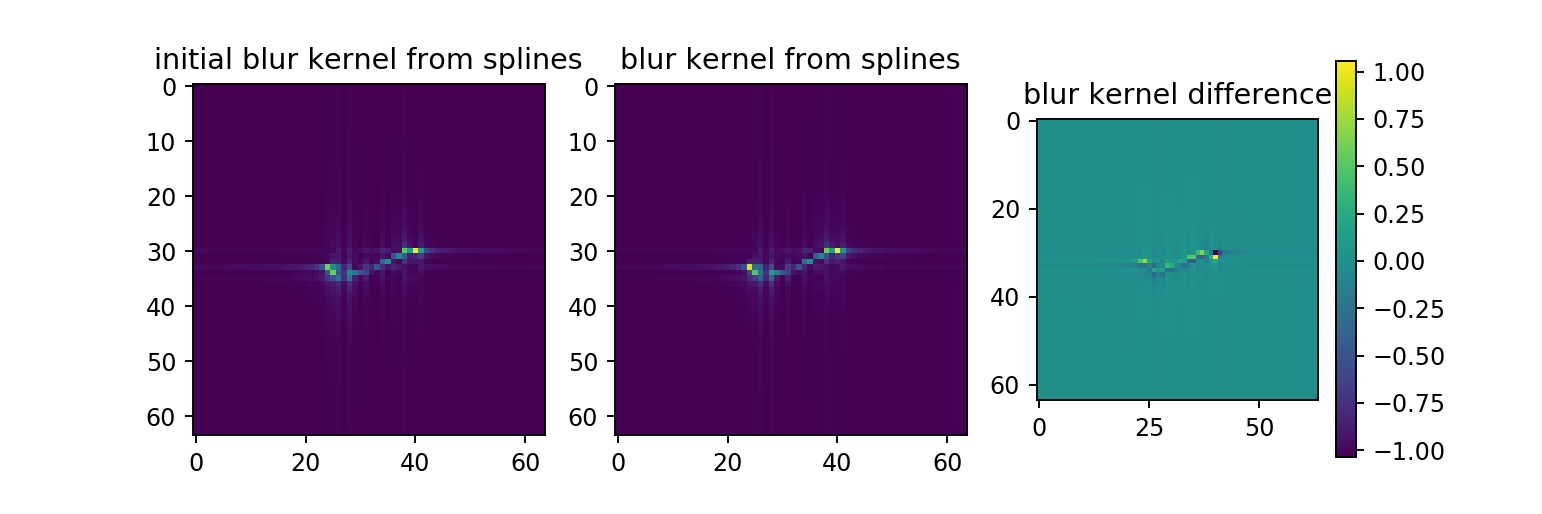

forward with position: (2.4947972+0.0034314736j) (8.502982+0.0019968918j)
[[5.7020884+0.j]]


In [45]:
# constructing blur kernels from the motion path splines 
blur_kernel_phaseramp = B * w
blur_kernel_phaseramp0 = B * w0


F = ops.FourierTransform(object_size, dtype=global_dtype, backend=global_backend)
plt.figure(figsize=(9,3));
plt.subplot(132); plt.imshow(np.abs(F.H * blur_kernel_phaseramp).reshape(object_size))
plt.title('blur kernel from splines')
plt.subplot(131); plt.imshow(np.abs(F.H * blur_kernel_phaseramp0).reshape(object_size))
plt.title('initial blur kernel from splines')
plt.subplot(133); plt.imshow(np.abs(F.H * blur_kernel_phaseramp_true.astype(np_dtype)).reshape(object_size) - np.abs(F.H * blur_kernel_phaseramp).reshape(object_size))
plt.title('blur kernel difference')
plt.colorbar()


print(objective * w)


In [46]:
w_y_fit = w[0:n_basis_splines[0]]
w_x_fit = w[n_basis_splines[0]:]

<IPython.core.display.Javascript object>


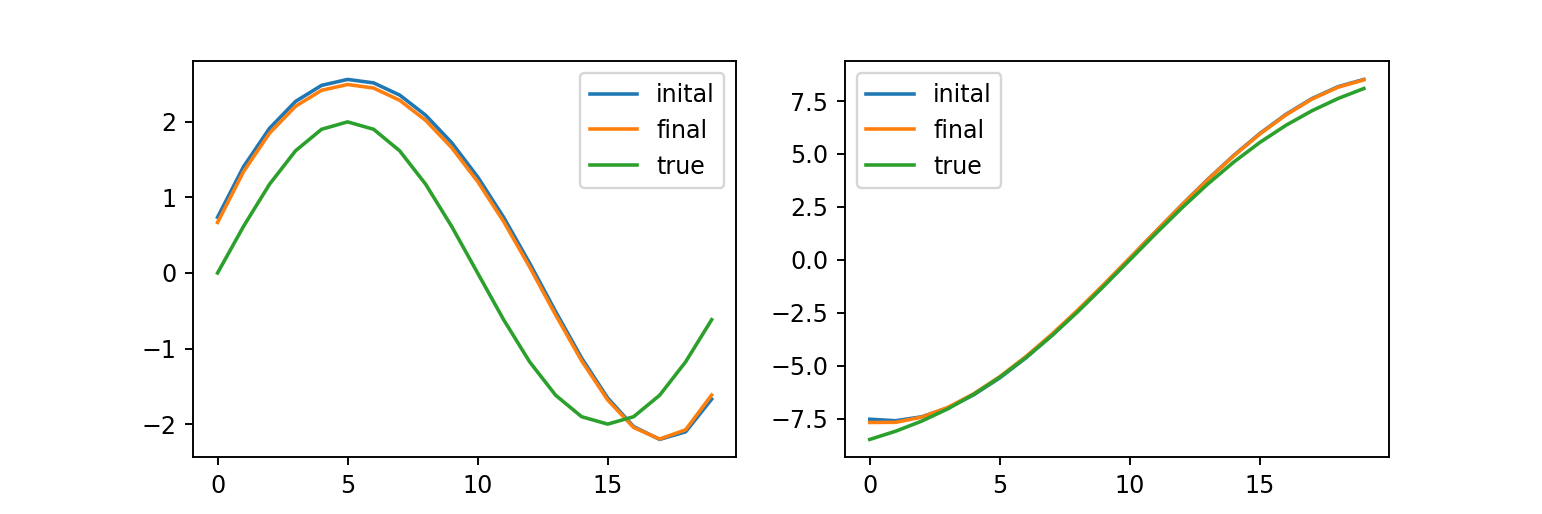

/home/sarah/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [47]:
yhat_fit = spl_y.dot(w_y_fit)
xhat_fit = spl_x.dot(w_x_fit)
yhat_0 = spl_y.dot(w0[0:n_basis_splines[0]])
xhat_0 = spl_x.dot(w0[n_basis_splines[0]:])

plt.figure(figsize=(9,3)); plt.subplot(1,2,1)
plt.plot(yhat_0, label='inital'); plt.plot(yhat_fit, label='final'); 
plt.plot(ys_offset, label = 'true'); plt.legend()

plt.subplot(1,2,2); plt.plot(xhat_0, label='inital'); plt.plot(xhat_fit, label='final'); 
plt.plot(xs_offset, label = 'true'); plt.legend()

# Fitting Blur Kernel using Positions

this method is generally less successful than the splines, and is also sensitive to initialization.

In [48]:
H = ops.PhaseRamp(object_size, dtype=global_dtype, backend=global_backend)

Hs = []
illums[0] * H
for t in range(n_illum):
    Hs.append(illums[t] * H)
    
Hfull = ops.Hstack(Hs)


In [49]:
L2 = ops.L2Norm(object_size, dtype=global_dtype, backend=global_backend)



In [50]:
offset_list_true = []
offset_list_straight = []
for i,pos in enumerate(zip(ys_offset, xs_offset)):
    y,x = pos
    offset_list_true.append(y)
    offset_list_true.append(x)
    offset_list_straight.append(0.0)
    offset_list_straight.append(x_offset + i)
    
offset_list_true = np.array(offset_list_true).astype(np_dtype)
offset_list_straight = np.array(offset_list_straight).astype(np_dtype)


In [51]:
blur_kernel_phaseramp_supposed_true = F.H * Hfull * offset_list_true

objective = L2 * (F.H * Hfull - blur_kernel_phaseramp_supposed_true.reshape(-1).astype(np_dtype))


In [52]:
objective * offset_list_true

array([[0.+0.j]], dtype=complex64)

Minimizing function:


<IPython.core.display.Latex object>

<IPython.core.display.Javascript object>


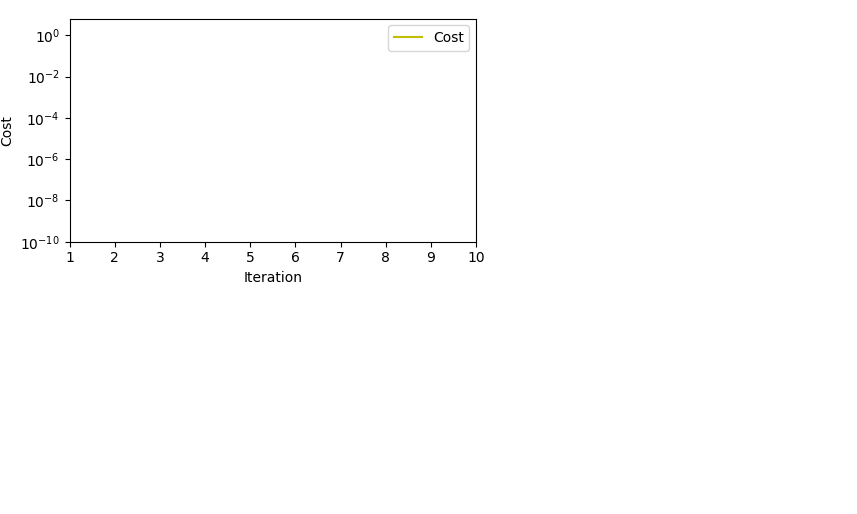

/home/sarah/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [53]:
num_iter = 10
pos0 = offset_list_true # np.zeros(offset_list_true.shape).astype(np_dtype) # np.ones(w.shape).astype(np_dtype)
#pos0 = offset_list_straight
pos0 += np.random.normal(size=pos0.shape).astype(np_dtype)

pos = iterative.GradientDescent(objective, display_type='plot',
                             convergence_tol=1e-14, let_diverge=True,
                             use_nesterov_acceleration=False, nesterov_restart_enabled=False,
                             step_size=None).solve(initialization=pos0, iteration_count=num_iter,
                                                                          use_log_y = True, max_iter_plot=num_iter)

In [ ]:
# constructing blur kernels from the motion path splines 
blur_kernel_phaseramp = Hfull * pos

F = ops.FourierTransform(object_size, dtype=global_dtype, backend=global_backend)
plt.figure(figsize=(10,2));
plt.subplot(141); plt.imshow(np.abs(F.H * Hfull * pos0).reshape(object_size))
plt.title('initial')
plt.subplot(142); plt.imshow(np.abs(F.H * blur_kernel_phaseramp).reshape(object_size))
plt.title('fit blur kernel from positions')
plt.subplot(143); plt.imshow(np.abs(blur_kernel_phaseramp_supposed_true).reshape(object_size))
plt.title('true blur kernel')
plt.subplot(144); plt.imshow(np.abs(F.H * blur_kernel_phaseramp_true.astype(np_dtype)).reshape(object_size) - np.abs(F.H * blur_kernel_phaseramp).reshape(object_size))
plt.title('blur kernel difference')
plt.colorbar()

